Link for the dataset:
https://drive.google.com/file/d/1VHQdYYHldT0n1gDTcwpuojg1eIWqX3MD/view?usp=sharing

# Import all necessary libraries

In [1]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.utils import resample

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(62)
tf.random.set_seed(62)
tf.keras.backend.clear_session()

Read the data into dataframe

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project/creditcard.csv")
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Visualize class distribution

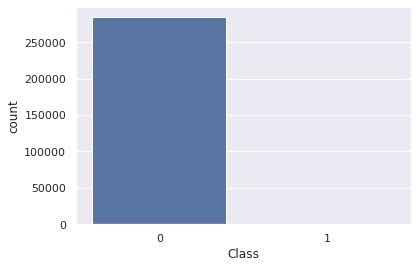

In [3]:
sns.set_theme(style="darkgrid")
sns.countplot(x="Class", data=df)

In [4]:
# Split the normal and fraud instance, use only 2000 normal instances
normal = df[df['Class'] == 0].sample(2000)
fraud = df[df['Class'] == 1]
print("Number of Nomral:", normal.shape[0], ", Number of Fraud:", fraud.shape[0])

# drop target colounm
df_view = normal.append(fraud).sample(frac=1).reset_index(drop=True)
X = df_view.drop(['Class'], axis = 1).values
Y = df_view["Class"].values
X.shape


Number of Nomral: 2000 , Number of Fraud: 492


(2492, 30)

# Visualize by using T-SNE

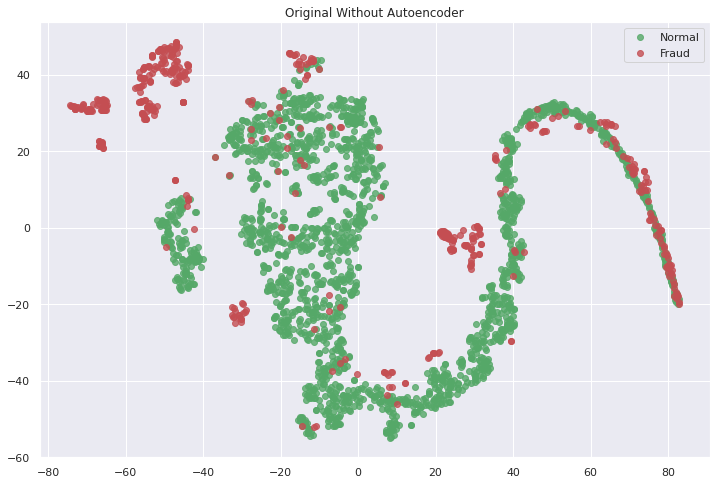

In [5]:
def tsne_plot(x1, y1, name="graph"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Normal')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.title(name)
    plt.show();
    
tsne_plot(X, Y, "Original Without Autoencoder")

Data preprocessing

In [6]:
x = df.drop(["Class"], axis=1)
y = df["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]
x_norm[0]

array([0.        , 0.93519234, 0.76649042, 0.8813649 , 0.31302266,
       0.76343873, 0.26766864, 0.26681518, 0.7864442 , 0.47531173,
       0.51060048, 0.25248432, 0.68090763, 0.3715906 , 0.63559053,
       0.4460837 , 0.43439239, 0.73717255, 0.65506586, 0.59486323,
       0.58294223, 0.56118439, 0.52299212, 0.66379298, 0.39125268,
       0.58512179, 0.39455679, 0.41897614, 0.31269663, 0.00582379])

# Building the Autoencoder structure

## Model 1: overcomplete, l1 regularization, without middle bottleneck block

In [7]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M1_input_ly")

# encoder layer
en_layers1 = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5), name="M1_en_ly1")(in_layer)
en_layers2 = Dense(50, activation='tanh', name="M1_en_ly2")(en_layers1)

# decoder layer
de_layers1 = Dense(50, activation='tanh', name="M1_de_ly1")(en_layers2)
de_layers2 = Dense(100, activation='tanh', name="M1_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='tanh',name="M1_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_01 = Model(in_layer, out_layer)
autoencoder_01.compile(optimizer="adadelta", loss="mse")
autoencoder_01.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M1_input_ly (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
M1_en_ly1 (Dense)            (None, 100)               3100      
_________________________________________________________________
M1_en_ly2 (Dense)            (None, 50)                5050      
_________________________________________________________________
M1_de_ly1 (Dense)            (None, 50)                2550      
_________________________________________________________________
M1_de_ly2 (Dense)            (None, 100)               5100      
_________________________________________________________________
M1_output_ly (Dense)         (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________________

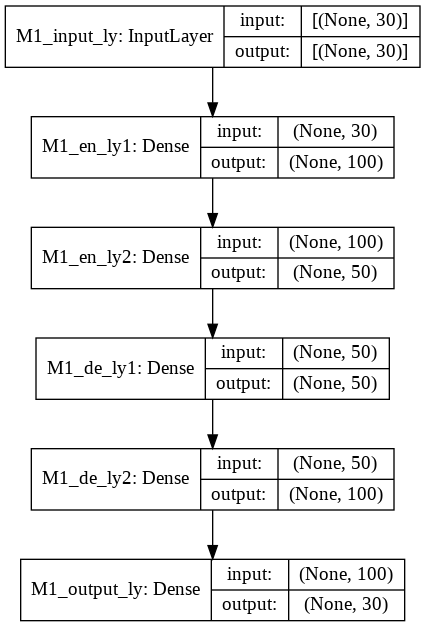

In [ ]:
plot_model(autoencoder_01,show_shapes=True)

In [8]:
au_01_his = autoencoder_01.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 6s 2ms/step - loss: 0.3007 - val_loss: 0.1296
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0892 - val_loss: 0.0231
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0157 - val_loss: 0.0081
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.005

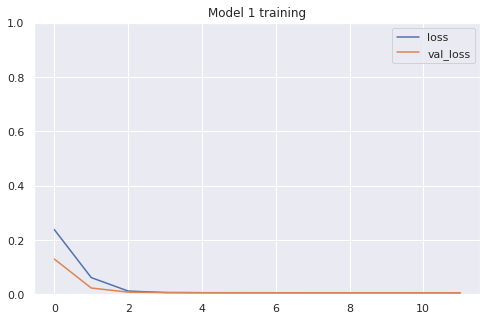

In [9]:
pd.DataFrame(au_01_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 1 training")
plt.gca().set_ylim(0, 1)
plt.show()

## Model 2: overcomplete, l1 regularization, with middle bottleneck block

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M2_input_ly")

# encoder layer
en_layers1 = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5), name="M2_en_ly1")(in_layer)
en_layers2 = Dense(50, activation='tanh', name="M2_en_ly2")(en_layers1)

# middle bottleneck block
mid_layer = Dense(30, activation='tanh', name="M2_mid_ly")(en_layers2)

# decoder layer
de_layers1 = Dense(50, activation='tanh', name="M2_de_ly1")(mid_layer)
de_layers2 = Dense(100, activation='tanh', name="M2_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='tanh',name="M2_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_02 = Model(in_layer, out_layer)
autoencoder_02.compile(optimizer="adadelta", loss="mse")
autoencoder_02.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M2_input_ly (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
M2_en_ly1 (Dense)            (None, 100)               3100      
_________________________________________________________________
M2_en_ly2 (Dense)            (None, 50)                5050      
_________________________________________________________________
M2_mid_ly (Dense)            (None, 30)                1530      
_________________________________________________________________
M2_de_ly1 (Dense)            (None, 50)                1550      
_________________________________________________________________
M2_de_ly2 (Dense)            (None, 100)               5100      
_________________________________________________________________
M2_output_ly (Dense)         (None, 30)                3030

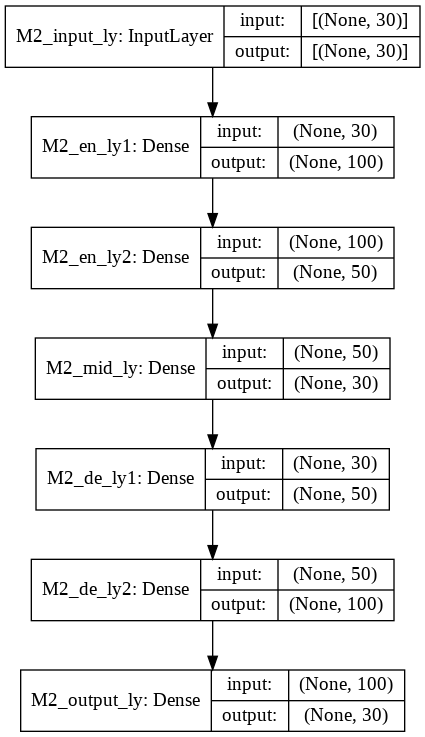

In [ ]:
plot_model(autoencoder_02,show_shapes=True)

In [ ]:
au_02_his = autoencoder_02.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.3254 - val_loss: 0.1383
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0931 - val_loss: 0.0233
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0159 - val_loss: 0.0084
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.005

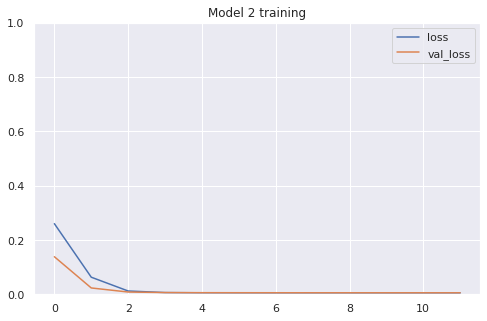

In [ ]:
pd.DataFrame(au_02_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 2 training")
plt.gca().set_ylim(0, 1)
plt.show()

## Model 3: overcomplete, without l1 regularization, without middle bottleneck block

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M3_input_ly")

# encoder layer
en_layers1 = Dense(100, activation='tanh', name="M3_en_ly1")(in_layer)
en_layers2 = Dense(50, activation='tanh', name="M3_en_ly2")(en_layers1)

# decoder layer
de_layers1 = Dense(50, activation='tanh', name="M3_de_ly1")(en_layers2)
de_layers2 = Dense(100, activation='tanh', name="M3_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='tanh',name="M3_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_03 = Model(in_layer, out_layer)
autoencoder_03.compile(optimizer="adadelta", loss="mse")
autoencoder_03.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M3_input_ly (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
M3_en_ly1 (Dense)            (None, 100)               3100      
_________________________________________________________________
M3_en_ly2 (Dense)            (None, 50)                5050      
_________________________________________________________________
M3_de_ly1 (Dense)            (None, 50)                2550      
_________________________________________________________________
M3_de_ly2 (Dense)            (None, 100)               5100      
_________________________________________________________________
M3_output_ly (Dense)         (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_______________________________________________________

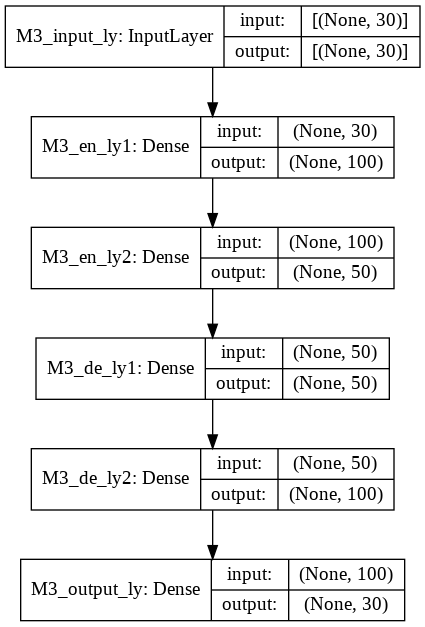

In [ ]:
plot_model(autoencoder_03,show_shapes=True)

In [ ]:
au_03_his = autoencoder_03.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2238 - val_loss: 0.0842
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0558 - val_loss: 0.0166
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0104 - val_loss: 0.0052
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.002

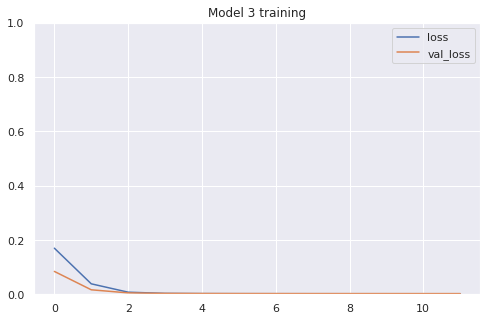

In [ ]:
pd.DataFrame(au_03_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 3 training")
plt.gca().set_ylim(0, 1)
plt.show()

## Model 4: overcomplete, without l1 regularization, with middle bottleneck block

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M4_input_ly")

# encoder layer
en_layers1 = Dense(100, activation='tanh', name="M4_en_ly1")(in_layer)
en_layers2 = Dense(50, activation='tanh', name="M4_en_ly2")(en_layers1)

# middle bottleneck block
mid_layer = Dense(30, activation='tanh', name="M4_mid_ly")(en_layers2)

# decoder layer
de_layers1 = Dense(50, activation='tanh', name="M4_de_ly1")(mid_layer)
de_layers2 = Dense(100, activation='tanh', name="M4_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='tanh',name="M4_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_04 = Model(in_layer, out_layer)
autoencoder_04.compile(optimizer="adadelta", loss="mse")
autoencoder_04.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M4_input_ly (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
M4_en_ly1 (Dense)            (None, 100)               3100      
_________________________________________________________________
M4_en_ly2 (Dense)            (None, 50)                5050      
_________________________________________________________________
M4_mid_ly (Dense)            (None, 30)                1530      
_________________________________________________________________
M4_de_ly1 (Dense)            (None, 50)                1550      
_________________________________________________________________
M4_de_ly2 (Dense)            (None, 100)               5100      
_________________________________________________________________
M4_output_ly (Dense)         (None, 30)                3030

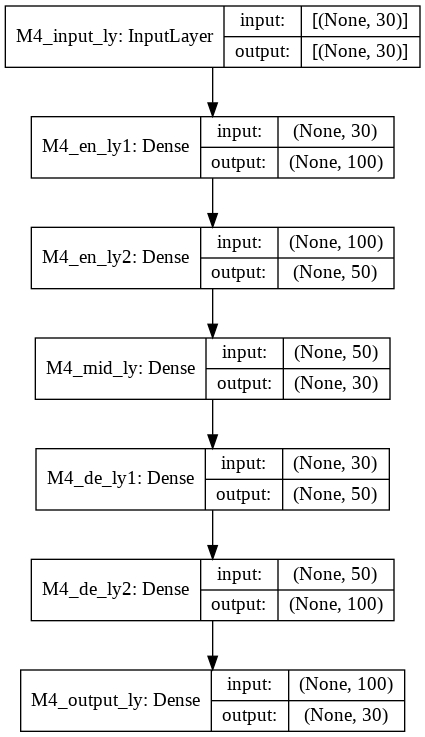

In [ ]:
plot_model(autoencoder_04,show_shapes=True)

In [ ]:
au_04_his = autoencoder_04.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.3219 - val_loss: 0.1227
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0794 - val_loss: 0.0174
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0111 - val_loss: 0.0045
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.002

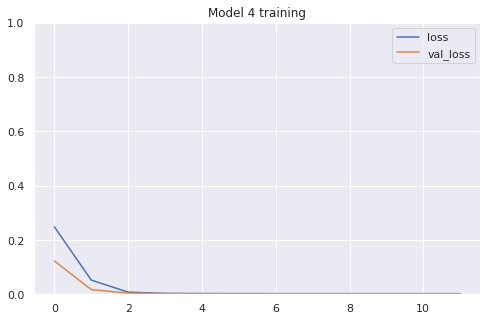

In [ ]:
pd.DataFrame(au_04_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 4 training")
plt.gca().set_ylim(0, 1)
plt.show()

## Model 5: undercomplete, without middle bottleneck block

In [10]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M5_input_ly")

# encoder layer
en_layers1 = Dense(20, activation='tanh', name="M5_en_ly1")(in_layer)
en_layers2 = Dense(10, activation='tanh', name="M5_en_ly2")(en_layers1)

# decoder layer
de_layers1 = Dense(10, activation='tanh', name="M5_de_ly1")(en_layers2)
de_layers2 = Dense(20, activation='tanh', name="M5_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='tanh',name="M5_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_05 = Model(in_layer, out_layer)
autoencoder_05.compile(optimizer="adadelta", loss="mse")
autoencoder_05.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M5_input_ly (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
M5_en_ly1 (Dense)            (None, 20)                620       
_________________________________________________________________
M5_en_ly2 (Dense)            (None, 10)                210       
_________________________________________________________________
M5_de_ly1 (Dense)            (None, 10)                110       
_________________________________________________________________
M5_de_ly2 (Dense)            (None, 20)                220       
_________________________________________________________________
M5_output_ly (Dense)         (None, 30)                630       
Total params: 1,790
Trainable params: 1,790
Non-trainable params: 0
_________________________________________________________

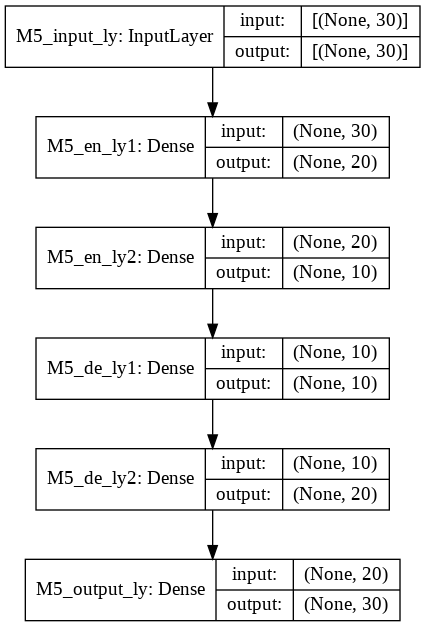

In [ ]:
plot_model(autoencoder_05,show_shapes=True)

In [11]:
au_05_his = autoencoder_05.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.3276 - val_loss: 0.2898
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2633 - val_loss: 0.2186
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1944 - val_loss: 0.1523
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1321 - val_loss: 0.0988
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0840 - val_loss: 0.0615
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0515 - val_loss: 0.0380
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0315 - val_loss: 0.0241
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0198 - val_loss: 0.0159
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0130 - val_loss: 0.0110
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.009

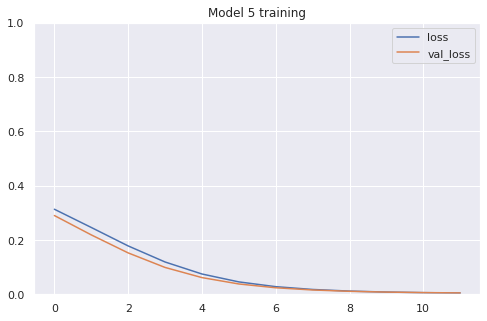

In [12]:
pd.DataFrame(au_05_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 5 training")
plt.gca().set_ylim(0, 1)
plt.show()

## Model 6: undercomplete, with middle bottleneck block

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M6_input_ly")

# encoder layer
en_layers1 = Dense(20, activation='tanh', name="M6_en_ly1")(in_layer)
en_layers2 = Dense(10, activation='tanh', name="M6_en_ly2")(en_layers1)

# middle bottleneck block
mid_layer = Dense(5, activation='tanh', name="M6_mid_ly")(en_layers2)

# decoder layer
de_layers1 = Dense(10, activation='tanh', name="M6_de_ly1")(mid_layer)
de_layers2 = Dense(20, activation='tanh', name="M6_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='tanh',name="M6_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_06 = Model(in_layer, out_layer)
autoencoder_06.compile(optimizer="adadelta", loss="mse")
autoencoder_06.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M6_input_ly (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
M6_en_ly1 (Dense)            (None, 20)                620       
_________________________________________________________________
M6_en_ly2 (Dense)            (None, 10)                210       
_________________________________________________________________
M6_mid_ly (Dense)            (None, 5)                 55        
_________________________________________________________________
M6_de_ly1 (Dense)            (None, 10)                60        
_________________________________________________________________
M6_de_ly2 (Dense)            (None, 20)                220       
_________________________________________________________________
M6_output_ly (Dense)         (None, 30)                630 

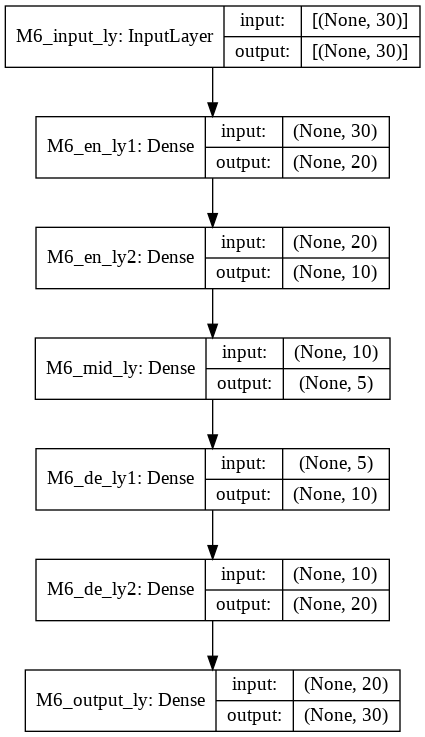

In [ ]:
plot_model(autoencoder_06,show_shapes=True)

In [ ]:
au_06_his = autoencoder_06.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.3826 - val_loss: 0.3459
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.3242 - val_loss: 0.2775
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2556 - val_loss: 0.2074
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1852 - val_loss: 0.1371
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1180 - val_loss: 0.0809
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0674 - val_loss: 0.0449
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0363 - val_loss: 0.0247
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0195 - val_loss: 0.0143
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0110 - val_loss: 0.0089
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.006

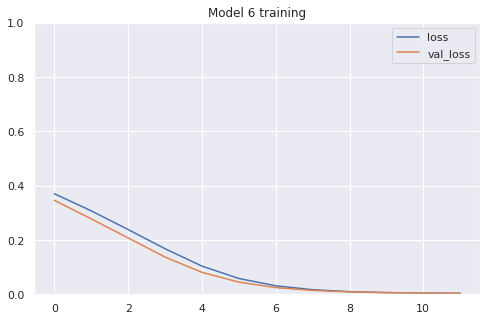

In [ ]:
pd.DataFrame(au_06_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 6 training")
plt.gca().set_ylim(0, 1)
plt.show()

## Model 7: undercomplete, without middle bottleneck block, deeper/more layers

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M7_input_ly")

# encoder layer
en_layers1 = Dense(20, activation='tanh', name="M7_en_ly1")(in_layer)
en_layers2 = Dense(10, activation='tanh', name="M7_en_ly2")(en_layers1)
en_layers3 = Dense(8, activation='tanh', name="M7_en_ly3")(en_layers2)
en_layers4 = Dense(4, activation='tanh', name="M7_en_ly4")(en_layers3)

# decoder layer
de_layers1 = Dense(4, activation='tanh', name="M7_de_ly1")(en_layers4)
de_layers2 = Dense(8, activation='tanh', name="M7_de_ly2")(de_layers1)
de_layers3 = Dense(10, activation='tanh', name="M7_de_ly3")(de_layers2)
de_layers4 = Dense(20, activation='tanh', name="M7_de_ly4")(de_layers3)

# output layer
out_layer = Dense(X.shape[1], activation='tanh',name="M7_output_ly")(de_layers4)

# combine encoder and decoder
autoencoder_07 = Model(in_layer, out_layer)
autoencoder_07.compile(optimizer="adadelta", loss="mse")
autoencoder_07.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M7_input_ly (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
M7_en_ly1 (Dense)            (None, 20)                620       
_________________________________________________________________
M7_en_ly2 (Dense)            (None, 10)                210       
_________________________________________________________________
M7_en_ly3 (Dense)            (None, 8)                 88        
_________________________________________________________________
M7_en_ly4 (Dense)            (None, 4)                 36        
_________________________________________________________________
M7_de_ly1 (Dense)            (None, 4)                 20        
_________________________________________________________________
M7_de_ly2 (Dense)            (None, 8)                 40  

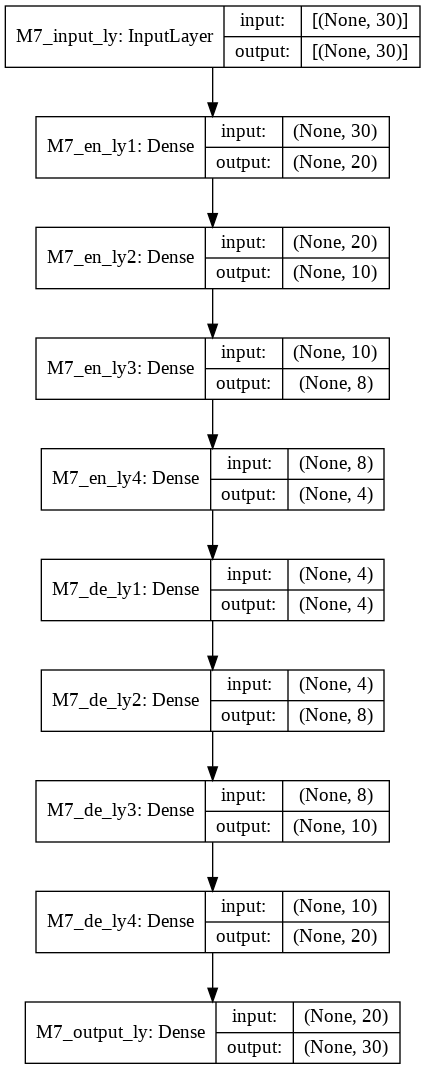

In [ ]:
plot_model(autoencoder_07,show_shapes=True)

In [ ]:
au_07_his = autoencoder_07.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 4s 2ms/step - loss: 0.3288 - val_loss: 0.3019
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2814 - val_loss: 0.2430
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2203 - val_loss: 0.1748
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1523 - val_loss: 0.1092
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0916 - val_loss: 0.0614
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0503 - val_loss: 0.0333
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0268 - val_loss: 0.0185
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0147 - val_loss: 0.0110
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0088 - val_loss: 0.0073
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.005

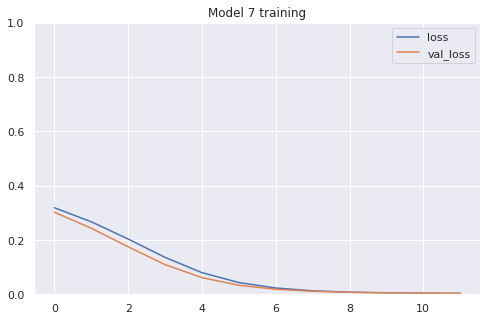

In [ ]:
pd.DataFrame(au_07_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 7 training")
plt.gca().set_ylim(0, 1)
plt.show()

## Model 8: undercomplete, with middle bottleneck block, deeper/more layers

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M8_input_ly")

# encoder layer
en_layers1 = Dense(20, activation='tanh', name="M8_en_ly1")(in_layer)
en_layers2 = Dense(10, activation='tanh', name="M8_en_ly2")(en_layers1)
en_layers3 = Dense(8, activation='tanh', name="M8_en_ly3")(en_layers2)
en_layers4 = Dense(4, activation='tanh', name="M8_en_ly4")(en_layers3)

# middle bottleneck block
mid_layer = Dense(2, activation='tanh', name="M8_mid_ly")(en_layers4)

# decoder layer
de_layers1 = Dense(4, activation='tanh', name="M8_de_ly1")(mid_layer)
de_layers2 = Dense(8, activation='tanh', name="M8_de_ly2")(de_layers1)
de_layers3 = Dense(10, activation='tanh', name="M8_de_ly3")(de_layers2)
de_layers4 = Dense(20, activation='tanh', name="M8_de_ly4")(de_layers3)

# output layer
out_layer = Dense(X.shape[1], activation='tanh',name="M8_output_ly")(de_layers4)

# combine encoder and decoder
autoencoder_08 = Model(in_layer, out_layer)
autoencoder_08.compile(optimizer="adadelta", loss="mse")
autoencoder_08.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M8_input_ly (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
M8_en_ly1 (Dense)            (None, 20)                620       
_________________________________________________________________
M8_en_ly2 (Dense)            (None, 10)                210       
_________________________________________________________________
M8_en_ly3 (Dense)            (None, 8)                 88        
_________________________________________________________________
M8_en_ly4 (Dense)            (None, 4)                 36        
_________________________________________________________________
M8_mid_ly (Dense)            (None, 2)                 10        
_________________________________________________________________
M8_de_ly1 (Dense)            (None, 4)                 12  

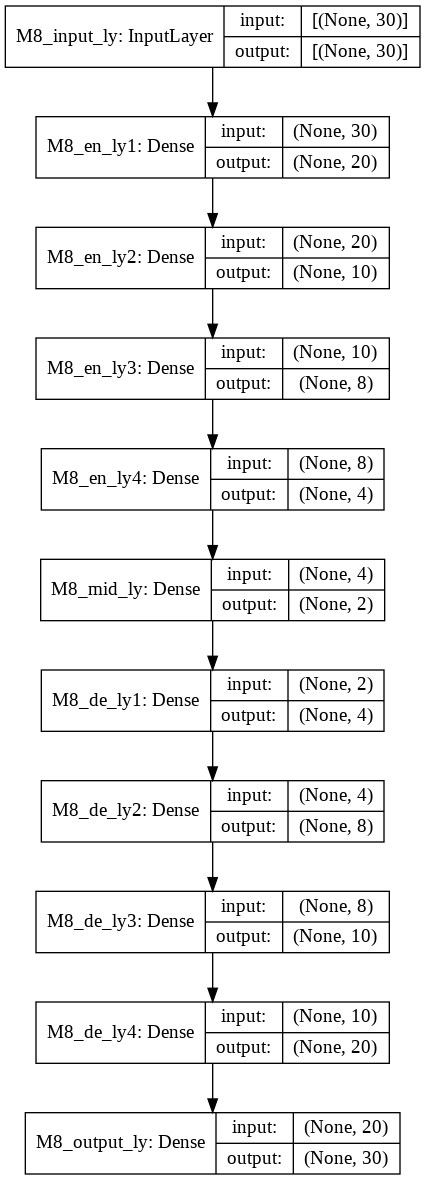

In [ ]:
plot_model(autoencoder_08,show_shapes=True)

In [ ]:
au_08_his = autoencoder_08.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 4s 2ms/step - loss: 0.3133 - val_loss: 0.3058
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2939 - val_loss: 0.2816
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2680 - val_loss: 0.2440
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2272 - val_loss: 0.1889
Epoch 5/12
1600/1600 [==============================] - 4s 2ms/step - loss: 0.1706 - val_loss: 0.1266
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1116 - val_loss: 0.0758
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0661 - val_loss: 0.0425
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0370 - val_loss: 0.0233
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0205 - val_loss: 0.0132
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.011

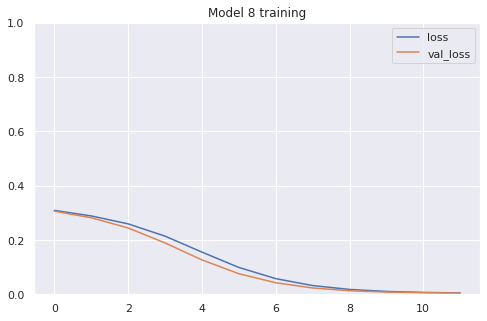

In [ ]:
pd.DataFrame(au_08_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 8 training")
plt.gca().set_ylim(0, 1)
plt.show()

# Obtain encoder representation

Model 1

In [14]:
encoder_layer_rep_m1 = Sequential([
                autoencoder_01.layers[0],
                autoencoder_01.layers[1],
                autoencoder_01.layers[2]                
])
norm_hid_rep_m1 = encoder_layer_rep_m1.predict(x_norm[:3000])
fraud_hid_rep_m1 = encoder_layer_rep_m1.predict(x_fraud[:200])

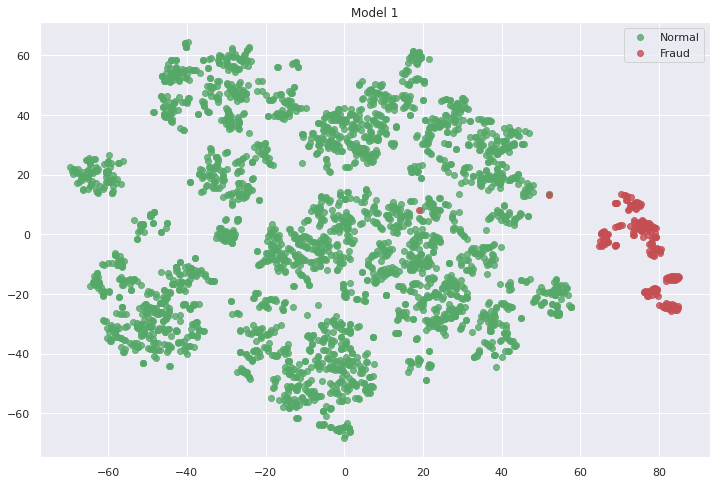

In [15]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m1, fraud_hid_rep_m1, axis = 0)
y_n = np.zeros(norm_hid_rep_m1.shape[0])
y_f = np.ones(fraud_hid_rep_m1.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "Model 1")

Model 2

In [ ]:
encoder_layer_rep_m2 = Sequential([
                autoencoder_02.layers[0],
                autoencoder_02.layers[1],
                autoencoder_02.layers[2],
                autoencoder_02.layers[3]                
])
norm_hid_rep_m2 = encoder_layer_rep_m2.predict(x_norm[:3000])
fraud_hid_rep_m2 = encoder_layer_rep_m2.predict(x_fraud[:200])

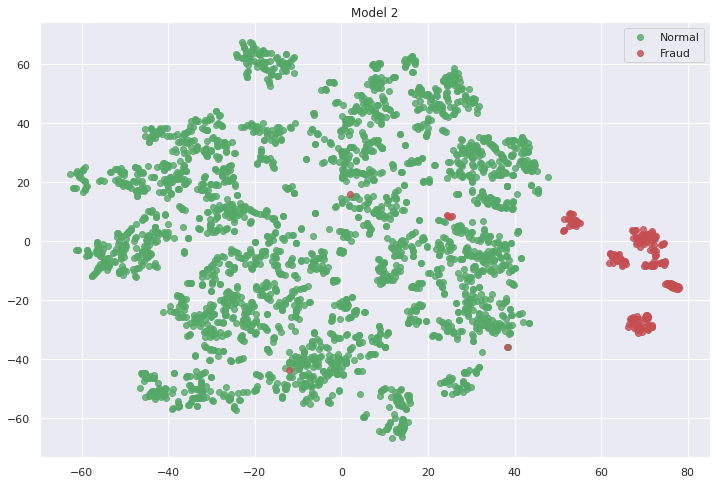

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m2, fraud_hid_rep_m2, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 2")

Model 3

In [ ]:
encoder_layer_rep_m3 = Sequential([
                autoencoder_03.layers[0],
                autoencoder_03.layers[1],
                autoencoder_03.layers[2]                
])
norm_hid_rep_m3 = encoder_layer_rep_m3.predict(x_norm[:3000])
fraud_hid_rep_m3 = encoder_layer_rep_m3.predict(x_fraud[:200])

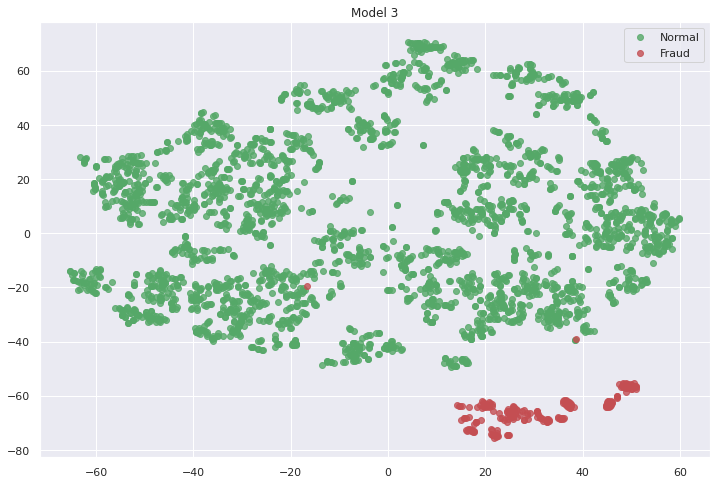

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m3, fraud_hid_rep_m3, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 3")

Model 4

In [ ]:
encoder_layer_rep_m4 = Sequential([
                autoencoder_04.layers[0],
                autoencoder_04.layers[1],
                autoencoder_04.layers[2],
                autoencoder_04.layers[3]                
])
norm_hid_rep_m4 = encoder_layer_rep_m4.predict(x_norm[:3000])
fraud_hid_rep_m4 = encoder_layer_rep_m4.predict(x_fraud[:200])

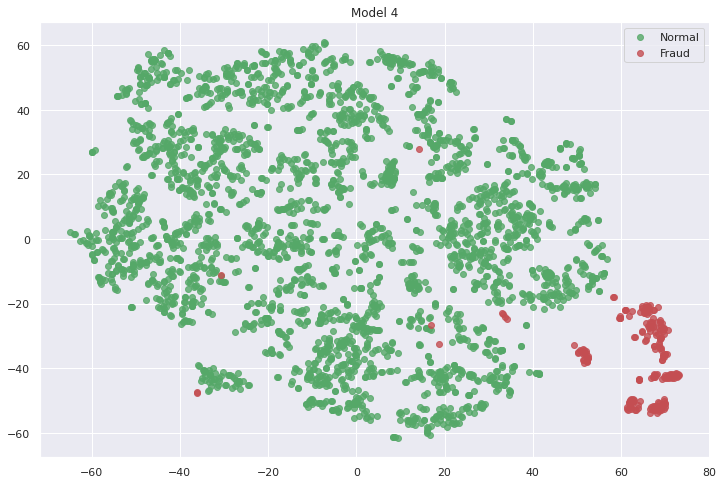

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m4, fraud_hid_rep_m4, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 4")

Model 5

In [ ]:
encoder_layer_rep_m5 = Sequential([
                autoencoder_05.layers[0],
                autoencoder_05.layers[1],
                autoencoder_05.layers[2]                
])
norm_hid_rep_m5 = encoder_layer_rep_m5.predict(x_norm[:3000])
fraud_hid_rep_m5 = encoder_layer_rep_m5.predict(x_fraud[:200])

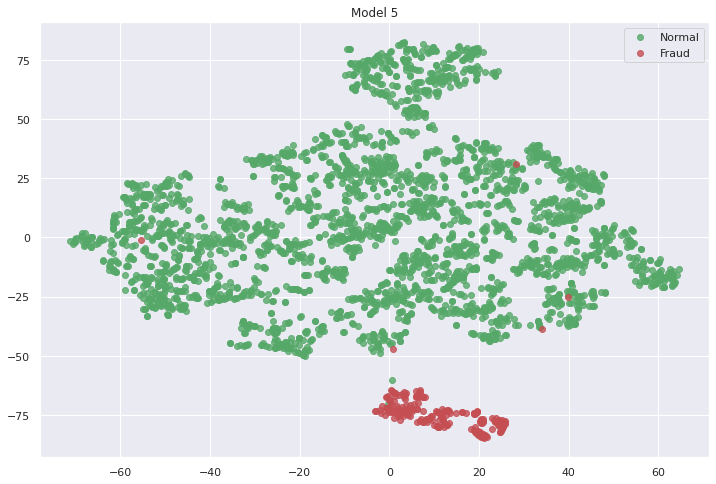

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m5, fraud_hid_rep_m5, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 5")

Model 6

In [ ]:
encoder_layer_rep_m6 = Sequential([
                autoencoder_06.layers[0],
                autoencoder_06.layers[1],
                autoencoder_06.layers[2],
                autoencoder_06.layers[3]                
])
norm_hid_rep_m6 = encoder_layer_rep_m6.predict(x_norm[:3000])
fraud_hid_rep_m6 = encoder_layer_rep_m6.predict(x_fraud[:200])

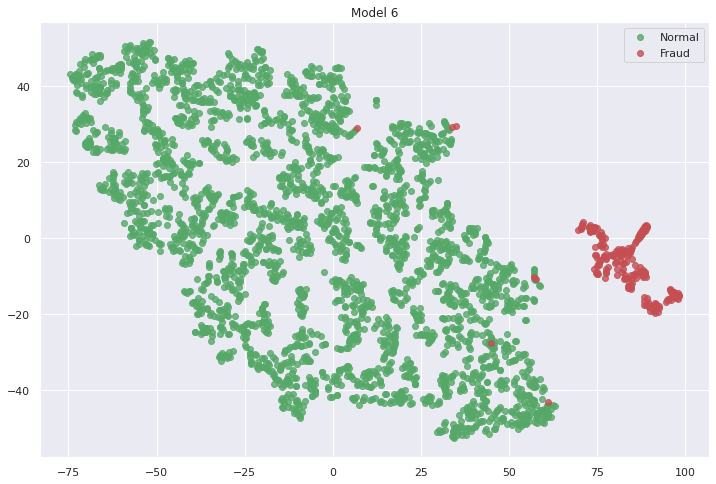

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m6, fraud_hid_rep_m6, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 6")

Model 7

In [ ]:
encoder_layer_rep_m7 = Sequential([
                autoencoder_07.layers[0],
                autoencoder_07.layers[1],
                autoencoder_07.layers[2],
                autoencoder_07.layers[3],
                autoencoder_07.layers[4]                
])
norm_hid_rep_m7 = encoder_layer_rep_m7.predict(x_norm[:3000])
fraud_hid_rep_m7 = encoder_layer_rep_m7.predict(x_fraud[:200])

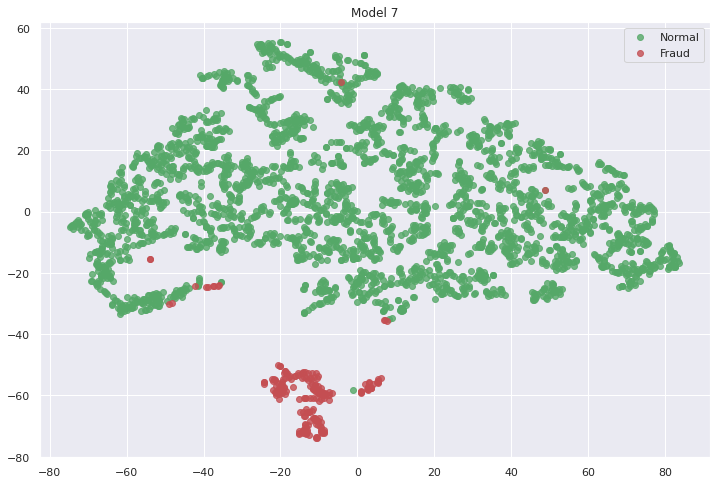

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m7, fraud_hid_rep_m7, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 7")

Model 8

In [ ]:
encoder_layer_rep_m8 = Sequential([
                autoencoder_08.layers[0],
                autoencoder_08.layers[1],
                autoencoder_08.layers[2],
                autoencoder_08.layers[3],
                autoencoder_08.layers[4],
                autoencoder_08.layers[5]                 
])
norm_hid_rep_m8 = encoder_layer_rep_m8.predict(x_norm[:3000])
fraud_hid_rep_m8 = encoder_layer_rep_m8.predict(x_fraud[:200])

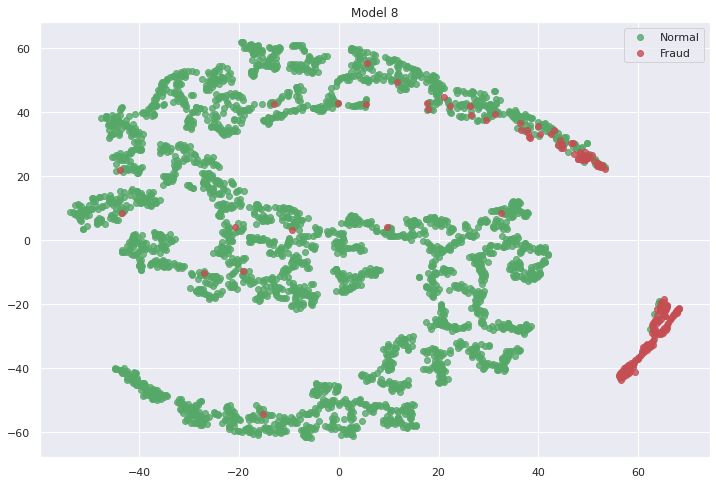

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m8, fraud_hid_rep_m8, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 8")

# Use RF for classification & Performance evaluation

Base RF Model Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.91      0.78      0.84       344

    accuracy                           1.00    199365
   macro avg       0.96      0.89      0.92    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   269     75]
 [    26 198995]]
Accuracy Score:  0.9994933915180698
Precision Score:  0.911864406779661
Recall Score:  0.7819767441860465
F1 Score:  0.8419405320813771


Text(0.5, 1.0, 'Base RF Precision-Recall curve')

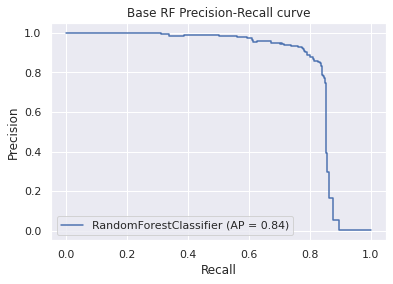

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(x_scale, y, test_size=0.7, stratify=y) 

clf_base = RandomForestClassifier().fit(train_x, train_y)
pred_y_base = clf_base.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_base))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_base, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_base))
print ("Precision Score: ", precision_score(val_y, pred_y_base))
print ("Recall Score: ", recall_score(val_y, pred_y_base))
print ("F1 Score: ", f1_score(val_y, pred_y_base))

# PR-AUC

disp_base = plot_precision_recall_curve(clf_base, val_x, val_y)
disp_base.ax_.set_title('Base RF Precision-Recall curve')


Model 1 Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.93      0.72      0.81       344

    accuracy                           1.00    199365
   macro avg       0.96      0.86      0.91    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   248     96]
 [    19 199002]]
Accuracy Score:  0.9994231685601785
Precision Score:  0.9288389513108615
Recall Score:  0.7209302325581395
F1 Score:  0.8117839607201309


Text(0.5, 1.0, 'Model 1 Precision-Recall curve')

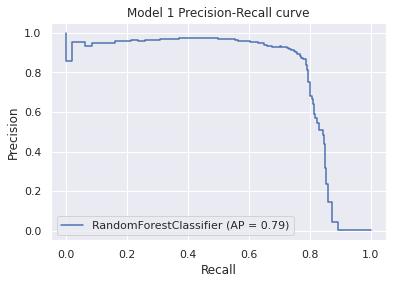

In [ ]:

train_x_transform_m1 = encoder_layer_rep_m1.predict(train_x)
val_x_transform_m1 = encoder_layer_rep_m1.predict(val_x)
clf_m1 = RandomForestClassifier().fit(train_x_transform_m1, train_y)
pred_y_m1 = clf_m1.predict(val_x_transform_m1)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m1))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m1, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m1))
print ("Precision Score: ", precision_score(val_y, pred_y_m1))
print ("Recall Score: ", recall_score(val_y, pred_y_m1))
print ("F1 Score: ", f1_score(val_y, pred_y_m1))

# PR-AUC

disp_m1 = plot_precision_recall_curve(clf_m1, val_x_transform_m1, val_y)
disp_m1.ax_.set_title('Model 1 Precision-Recall curve')


Model 2 Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.94      0.63      0.75       344

    accuracy                           1.00    199365
   macro avg       0.97      0.82      0.88    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   217    127]
 [    14 199007]]
Accuracy Score:  0.9992927544955232
Precision Score:  0.9393939393939394
Recall Score:  0.6308139534883721
F1 Score:  0.7547826086956522


Text(0.5, 1.0, 'Model 2 Precision-Recall curve')

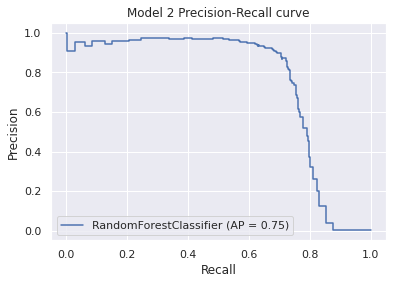

In [ ]:
train_x_transform_m2 = encoder_layer_rep_m2.predict(train_x)
val_x_transform_m2 = encoder_layer_rep_m2.predict(val_x)
clf_m2 = RandomForestClassifier().fit(train_x_transform_m2, train_y)
pred_y_m2 = clf_m2.predict(val_x_transform_m2)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m2))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m2, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m2))
print ("Precision Score: ", precision_score(val_y, pred_y_m2))
print ("Recall Score: ", recall_score(val_y, pred_y_m2))
print ("F1 Score: ", f1_score(val_y, pred_y_m2))

# PR-AUC

disp_m2 = plot_precision_recall_curve(clf_m2, val_x_transform_m2, val_y)
disp_m2.ax_.set_title('Model 2 Precision-Recall curve')

Model 3 Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.90      0.69      0.78       344

    accuracy                           1.00    199365
   macro avg       0.95      0.85      0.89    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   239    105]
 [    26 198995]]
Accuracy Score:  0.9993429137511599
Precision Score:  0.9018867924528302
Recall Score:  0.6947674418604651
F1 Score:  0.7848932676518884


Text(0.5, 1.0, 'Model 3 Precision-Recall curve')

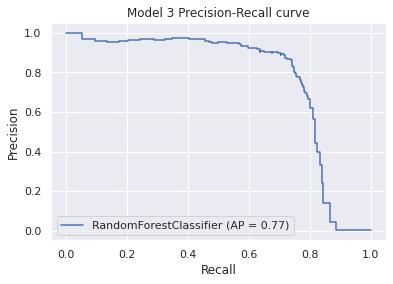

In [ ]:
train_x_transform_m3 = encoder_layer_rep_m3.predict(train_x)
val_x_transform_m3 = encoder_layer_rep_m3.predict(val_x)
clf_m3 = RandomForestClassifier().fit(train_x_transform_m3, train_y)
pred_y_m3 = clf_m3.predict(val_x_transform_m3)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m3))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m3, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m3))
print ("Precision Score: ", precision_score(val_y, pred_y_m3))
print ("Recall Score: ", recall_score(val_y, pred_y_m3))
print ("F1 Score: ", f1_score(val_y, pred_y_m3))

# PR-AUC

disp_m3 = plot_precision_recall_curve(clf_m3, val_x_transform_m3, val_y)
disp_m3.ax_.set_title('Model 3 Precision-Recall curve')

Model 4 Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.92      0.70      0.79       344

    accuracy                           1.00    199365
   macro avg       0.96      0.85      0.90    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   240    104]
 [    21 199000]]
Accuracy Score:  0.9993730093045419
Precision Score:  0.9195402298850575
Recall Score:  0.6976744186046512
F1 Score:  0.793388429752066


Text(0.5, 1.0, 'Model 4 Precision-Recall curve')

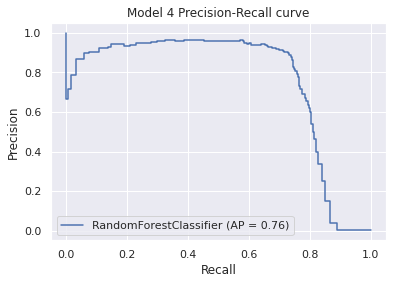

In [ ]:
train_x_transform_m4 = encoder_layer_rep_m4.predict(train_x)
val_x_transform_m4 = encoder_layer_rep_m4.predict(val_x)
clf_m4 = RandomForestClassifier().fit(train_x_transform_m4, train_y)
pred_y_m4 = clf_m4.predict(val_x_transform_m4)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m4))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m4, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m4))
print ("Precision Score: ", precision_score(val_y, pred_y_m4))
print ("Recall Score: ", recall_score(val_y, pred_y_m4))
print ("F1 Score: ", f1_score(val_y, pred_y_m4))

# PR-AUC

disp_m4 = plot_precision_recall_curve(clf_m4, val_x_transform_m4, val_y)
disp_m4.ax_.set_title('Model 4 Precision-Recall curve')

Model 5 Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.96      0.45      0.62       344

    accuracy                           1.00    199365
   macro avg       0.98      0.73      0.81    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   156    188]
 [     7 199014]]
Accuracy Score:  0.9990218945150854
Precision Score:  0.9570552147239264
Recall Score:  0.45348837209302323
F1 Score:  0.6153846153846154


Text(0.5, 1.0, 'Model 5 Precision-Recall curve')

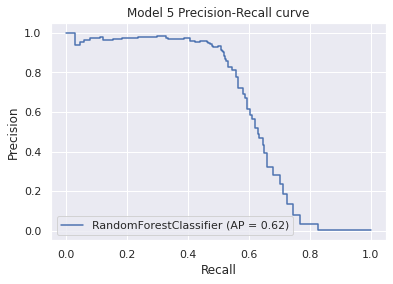

In [ ]:
train_x_transform_m5 = encoder_layer_rep_m5.predict(train_x)
val_x_transform_m5 = encoder_layer_rep_m5.predict(val_x)
clf_m5 = RandomForestClassifier().fit(train_x_transform_m5, train_y)
pred_y_m5 = clf_m5.predict(val_x_transform_m5)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m5))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m5, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m5))
print ("Precision Score: ", precision_score(val_y, pred_y_m5))
print ("Recall Score: ", recall_score(val_y, pred_y_m5))
print ("F1 Score: ", f1_score(val_y, pred_y_m5))

# PR-AUC

disp_m5 = plot_precision_recall_curve(clf_m5, val_x_transform_m5, val_y)
disp_m5.ax_.set_title('Model 5 Precision-Recall curve')

Model 6 Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.80      0.39      0.53       344

    accuracy                           1.00    199365
   macro avg       0.90      0.70      0.76    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   135    209]
 [    33 198988]]
Accuracy Score:  0.9987861460135932
Precision Score:  0.8035714285714286
Recall Score:  0.39244186046511625
F1 Score:  0.52734375


Text(0.5, 1.0, 'Model 6 Precision-Recall curve')

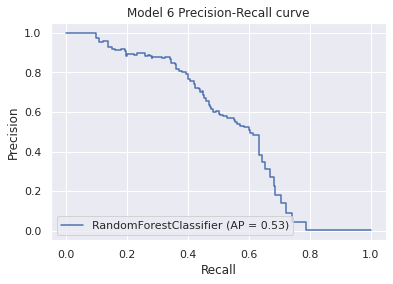

In [ ]:
train_x_transform_m6 = encoder_layer_rep_m6.predict(train_x)
val_x_transform_m6 = encoder_layer_rep_m6.predict(val_x)
clf_m6 = RandomForestClassifier().fit(train_x_transform_m6, train_y)
pred_y_m6 = clf_m6.predict(val_x_transform_m6)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m6))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m6, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m6))
print ("Precision Score: ", precision_score(val_y, pred_y_m6))
print ("Recall Score: ", recall_score(val_y, pred_y_m6))
print ("F1 Score: ", f1_score(val_y, pred_y_m6))

# PR-AUC

disp_m6 = plot_precision_recall_curve(clf_m6, val_x_transform_m6, val_y)
disp_m6.ax_.set_title('Model 6 Precision-Recall curve')

Model 7 Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.90      0.52      0.66       344

    accuracy                           1.00    199365
   macro avg       0.95      0.76      0.83    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   178    166]
 [    20 199001]]
Accuracy Score:  0.9990670378451584
Precision Score:  0.898989898989899
Recall Score:  0.5174418604651163
F1 Score:  0.6568265682656828


Text(0.5, 1.0, 'Model 7 Precision-Recall curve')

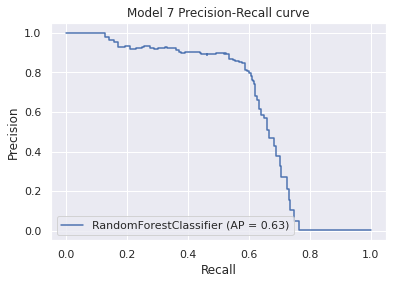

In [ ]:
train_x_transform_m7 = encoder_layer_rep_m7.predict(train_x)
val_x_transform_m7 = encoder_layer_rep_m7.predict(val_x)
clf_m7 = RandomForestClassifier().fit(train_x_transform_m7, train_y)
pred_y_m7 = clf_m7.predict(val_x_transform_m7)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m7))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m7, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m7))
print ("Precision Score: ", precision_score(val_y, pred_y_m7))
print ("Recall Score: ", recall_score(val_y, pred_y_m7))
print ("F1 Score: ", f1_score(val_y, pred_y_m7))

# PR-AUC

disp_m7 = plot_precision_recall_curve(clf_m7, val_x_transform_m7, val_y)
disp_m7.ax_.set_title('Model 7 Precision-Recall curve')

Model 8 Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.79      0.18      0.29       344

    accuracy                           1.00    199365
   macro avg       0.90      0.59      0.65    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[    62    282]
 [    16 199005]]
Accuracy Score:  0.998505254182028
Precision Score:  0.7948717948717948
Recall Score:  0.18023255813953487
F1 Score:  0.2938388625592417


Text(0.5, 1.0, 'Model 8 Precision-Recall curve')

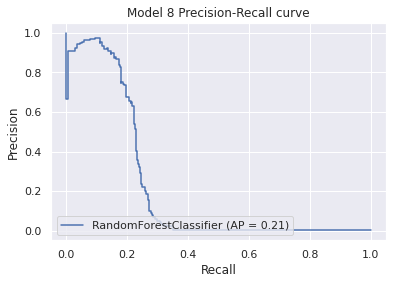

In [ ]:
train_x_transform_m8 = encoder_layer_rep_m8.predict(train_x)
val_x_transform_m8 = encoder_layer_rep_m8.predict(val_x)
clf_m8 = RandomForestClassifier().fit(train_x_transform_m8, train_y)
pred_y_m8 = clf_m8.predict(val_x_transform_m8)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m8))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m8, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m8))
print ("Precision Score: ", precision_score(val_y, pred_y_m8))
print ("Recall Score: ", recall_score(val_y, pred_y_m8))
print ("F1 Score: ", f1_score(val_y, pred_y_m8))

# PR-AUC

disp_m8 = plot_precision_recall_curve(clf_m8, val_x_transform_m8, val_y)
disp_m8.ax_.set_title('Model 8 Precision-Recall curve')

# Resampling before RF classification

In [ ]:
normal = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]
normal.shape
fraud.shape


(284315, 31)

In [ ]:
# Increase the number of fraud to half of the normal
upsample_fraud = resample(fraud,
                          replace=True,
                          n_samples=int(284315/2))

# Join the fraud upsample with normal
resample_data = pd.concat([normal, upsample_fraud])
resample_data.Class.value_counts()

0    284315
1    142157
Name: Class, dtype: int64

In [ ]:
# Scale the resample data

x_res = resample_data.drop(["Class"], axis=1)
y_res = resample_data["Class"].values

x_res_scale = preprocessing.MinMaxScaler().fit_transform(x_res.values)

# Split the resample data
train_x_res, val_x_res, train_y_res, val_y_res = train_test_split(x_res_scale, y_res, test_size=0.7, stratify=y_res)

Model 1


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       1.00      1.00      1.00     99510

    accuracy                           1.00    298531
   macro avg       1.00      1.00      1.00    298531
weighted avg       1.00      1.00      1.00    298531


Confusion Matrix: 
 [[ 99510      0]
 [    42 198979]]
Accuracy Score:  0.9998593110933203
Precision Score:  0.9995781099324976
Recall Score:  1.0
F1 Score:  0.999789010459053


Text(0.5, 1.0, 'Model 1 with Resampling Precision-Recall curve')

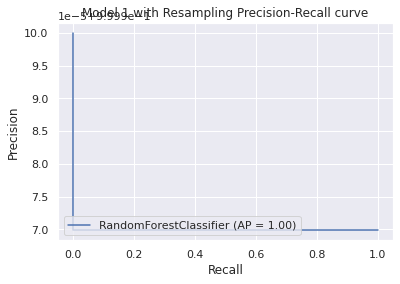

In [ ]:
train_x_transform_m1_res = encoder_layer_rep_m1.predict(train_x_res)
val_x_transform_m1_res = encoder_layer_rep_m1.predict(val_x_res)
clf_m1_res = RandomForestClassifier().fit(train_x_transform_m1_res, train_y_res)
pred_y_m1_res = clf_m1_res.predict(val_x_transform_m1_res)

print ("")
print ("Classification Report: ")
print (classification_report(val_y_res, pred_y_m1_res))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y_res, pred_y_m1_res, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y_res, pred_y_m1_res))
print ("Precision Score: ", precision_score(val_y_res, pred_y_m1_res))
print ("Recall Score: ", recall_score(val_y_res, pred_y_m1_res))
print ("F1 Score: ", f1_score(val_y_res, pred_y_m1_res))

# PR-AUC

disp_m1_res = plot_precision_recall_curve(clf_m1_res, val_x_transform_m1_res, val_y_res)
disp_m1_res.ax_.set_title('Model 1 with Resampling Precision-Recall curve')

Model 5


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       1.00      1.00      1.00     99510

    accuracy                           1.00    298531
   macro avg       1.00      1.00      1.00    298531
weighted avg       1.00      1.00      1.00    298531


Confusion Matrix: 
 [[ 99510      0]
 [    32 198989]]
Accuracy Score:  0.9998928084520535
Precision Score:  0.9996785276566675
Recall Score:  1.0
F1 Score:  0.9998392379880634


Text(0.5, 1.0, 'Model 5 with Resampling Precision-Recall curve')

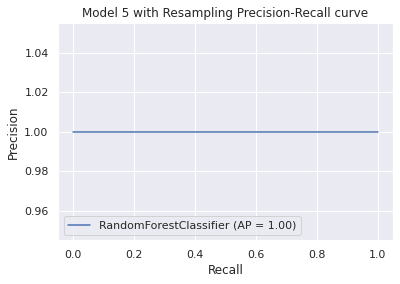

In [ ]:
train_x_transform_m5_res = encoder_layer_rep_m5.predict(train_x_res)
val_x_transform_m5_res = encoder_layer_rep_m5.predict(val_x_res)
clf_m5_res = RandomForestClassifier().fit(train_x_transform_m5_res, train_y_res)
pred_y_m5_res = clf_m5_res.predict(val_x_transform_m5_res)

print ("")
print ("Classification Report: ")
print (classification_report(val_y_res, pred_y_m5_res))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y_res, pred_y_m5_res, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y_res, pred_y_m5_res))
print ("Precision Score: ", precision_score(val_y_res, pred_y_m5_res))
print ("Recall Score: ", recall_score(val_y_res, pred_y_m5_res))
print ("F1 Score: ", f1_score(val_y_res, pred_y_m5_res))

# PR-AUC

disp_m5_res = plot_precision_recall_curve(clf_m5_res, val_x_transform_m5_res, val_y_res)
disp_m5_res.ax_.set_title('Model 5 with Resampling Precision-Recall curve')

# Use reconstruction representation at the end of autoencoder for RF classification

Model 1

Visualization

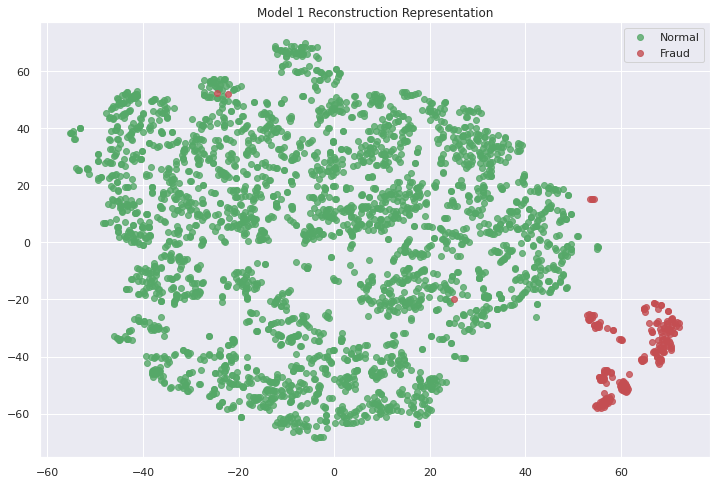

In [16]:
norm_recon_rep_m1 = autoencoder_01.predict(x_norm[:3000])
fraud_recon_rep_m1 = autoencoder_01.predict(x_fraud[:200])
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_recon_rep_m1, fraud_recon_rep_m1, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 1 Reconstruction Representation")


Classification


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.93      0.60      0.73       344

    accuracy                           1.00    199365
   macro avg       0.97      0.80      0.86    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   205    139]
 [    15 199006]]
Accuracy Score:  0.9992275474631956
Precision Score:  0.9318181818181818
Recall Score:  0.5959302325581395
F1 Score:  0.7269503546099291


Text(0.5, 1.0, 'Model 1 Using Reconstruction Errors Precision-Recall curve')

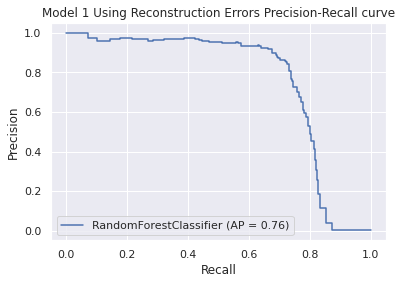

In [ ]:
train_x_reError_m1 = autoencoder_01.predict(train_x)
val_x_reError_m1 = autoencoder_01.predict(val_x)
clf_reError_m1 = RandomForestClassifier().fit(train_x_reError_m1, train_y)
pred_y_reError_m1 = clf_reError_m1.predict(val_x_reError_m1)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_reError_m1))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_reError_m1, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_reError_m1))
print ("Precision Score: ", precision_score(val_y, pred_y_reError_m1))
print ("Recall Score: ", recall_score(val_y, pred_y_reError_m1))
print ("F1 Score: ", f1_score(val_y, pred_y_reError_m1))

# PR-AUC

disp_reError_m1 = plot_precision_recall_curve(clf_reError_m1, val_x_reError_m1, val_y)
disp_reError_m1.ax_.set_title('Model 1 Using Reconstruction Errors Precision-Recall curve')

Model 5

Visualization

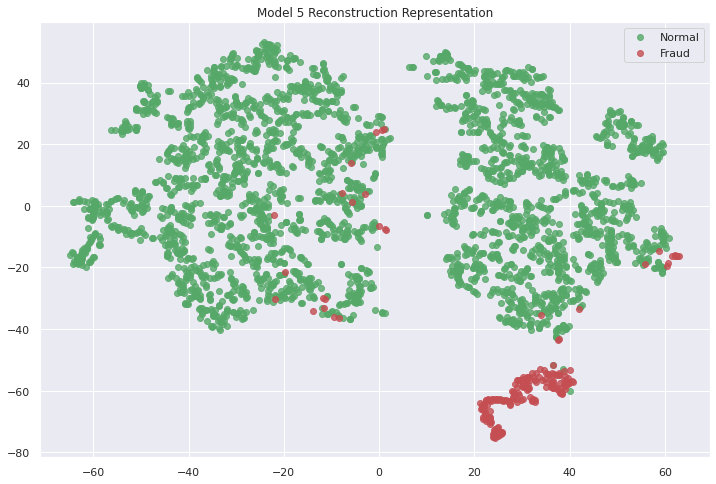

In [17]:
norm_recon_rep_m5 = autoencoder_05.predict(x_norm[:3000])
fraud_recon_rep_m5 = autoencoder_05.predict(x_fraud[:200])
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_recon_rep_m5, fraud_recon_rep_m5, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 5 Reconstruction Representation")

Classification


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.92      0.51      0.65       344

    accuracy                           1.00    199365
   macro avg       0.96      0.75      0.83    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   175    169]
 [    16 199005]]
Accuracy Score:  0.9990720537707221
Precision Score:  0.9162303664921466
Recall Score:  0.5087209302325582
F1 Score:  0.6542056074766355


Text(0.5, 1.0, 'Model 5 Using Reconstruction Errors Precision-Recall curve')

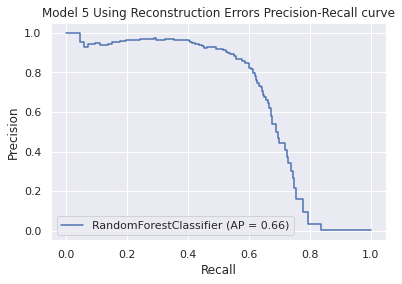

In [ ]:
train_x_reError_m5 = autoencoder_05.predict(train_x)
val_x_reError_m5 = autoencoder_05.predict(val_x)
clf_reError_m5 = RandomForestClassifier().fit(train_x_reError_m5, train_y)
pred_y_reError_m5 = clf_reError_m5.predict(val_x_reError_m5)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_reError_m5))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_reError_m5, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_reError_m5))
print ("Precision Score: ", precision_score(val_y, pred_y_reError_m5))
print ("Recall Score: ", recall_score(val_y, pred_y_reError_m5))
print ("F1 Score: ", f1_score(val_y, pred_y_reError_m5))

# PR-AUC

disp_reError_m5 = plot_precision_recall_curve(clf_reError_m5, val_x_reError_m5, val_y)
disp_reError_m5.ax_.set_title('Model 5 Using Reconstruction Errors Precision-Recall curve')

# Using different Optimizer and activation functions (Model 1 Based)

##Optimizer: adadelta ; Activation function: RELU

Model building

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M1relu_input_ly")

# encoder layer
en_layers1 = Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5), name="M1relu_en_ly1")(in_layer)
en_layers2 = Dense(50, activation='relu', name="M1relu_en_ly2")(en_layers1)

# decoder layer
de_layers1 = Dense(50, activation='relu', name="M1relu_de_ly1")(en_layers2)
de_layers2 = Dense(100, activation='relu', name="M1relu_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='relu',name="M1relu_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_01_relu = Model(in_layer, out_layer)
autoencoder_01_relu.compile(optimizer="adadelta", loss="mse")
autoencoder_01_relu.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M1relu_input_ly (InputLayer) [(None, 30)]              0         
_________________________________________________________________
M1relu_en_ly1 (Dense)        (None, 100)               3100      
_________________________________________________________________
M1relu_en_ly2 (Dense)        (None, 50)                5050      
_________________________________________________________________
M1relu_de_ly1 (Dense)        (None, 50)                2550      
_________________________________________________________________
M1relu_de_ly2 (Dense)        (None, 100)               5100      
_________________________________________________________________
M1relu_output_ly (Dense)     (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_______________________________________________________

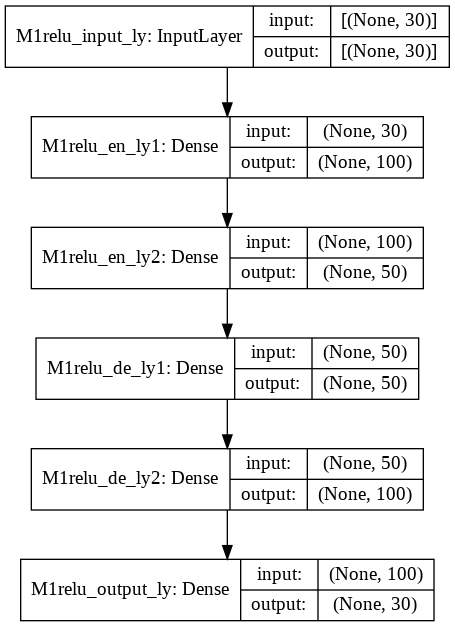

In [ ]:
plot_model(autoencoder_01_relu,show_shapes=True)

In [ ]:
au_01_relu_his = autoencoder_01_relu.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2461 - val_loss: 0.2087
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1920 - val_loss: 0.1631
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1568 - val_loss: 0.1514
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1482 - val_loss: 0.1427
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1413 - val_loss: 0.1396
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1396 - val_loss: 0.1389
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1393 - val_loss: 0.1387
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1392 - val_loss: 0.1387
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1392 - val_loss: 0.1386
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.139

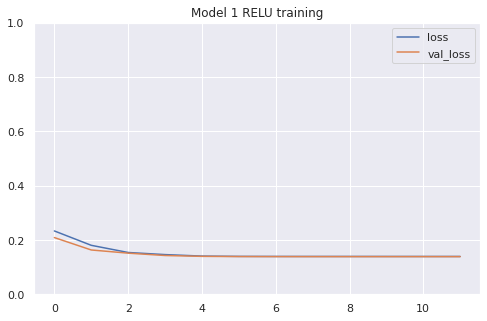

In [ ]:
pd.DataFrame(au_01_relu_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 1 RELU training")
plt.gca().set_ylim(0, 1)
plt.show()

Visualization

In [ ]:
encoder_layer_rep_m1_relu = Sequential([
                autoencoder_01_relu.layers[0],
                autoencoder_01_relu.layers[1],
                autoencoder_01_relu.layers[2]                
])
norm_hid_rep_m1_relu = encoder_layer_rep_m1_relu.predict(x_norm[:3000])
fraud_hid_rep_m1_relu = encoder_layer_rep_m1_relu.predict(x_fraud[:200])

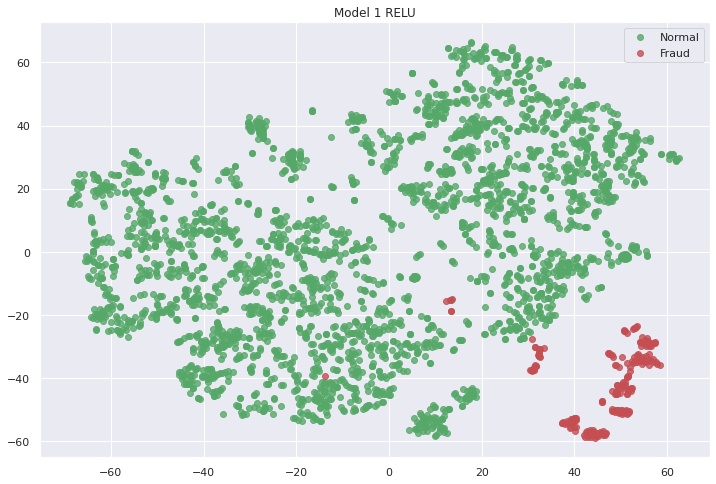

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m1_relu, fraud_hid_rep_m1_relu, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 1 RELU")

Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.91      0.64      0.75       344

    accuracy                           1.00    199365
   macro avg       0.95      0.82      0.88    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   221    123]
 [    22 198999]]
Accuracy Score:  0.9992726907932686
Precision Score:  0.9094650205761317
Recall Score:  0.6424418604651163
F1 Score:  0.7529812606473595


Text(0.5, 1.0, 'Model 1 RELU Precision-Recall curve')

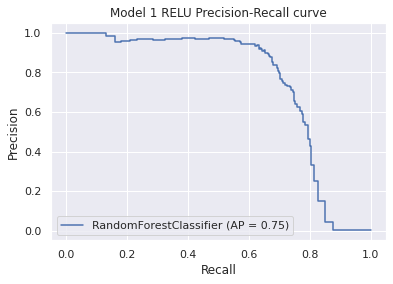

In [ ]:
train_x_transform_m1_relu = encoder_layer_rep_m1_relu.predict(train_x)
val_x_transform_m1_relu = encoder_layer_rep_m1_relu.predict(val_x)
clf_m1_relu = RandomForestClassifier().fit(train_x_transform_m1_relu, train_y)
pred_y_m1_relu = clf_m1_relu.predict(val_x_transform_m1_relu)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m1_relu))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m1_relu, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m1_relu))
print ("Precision Score: ", precision_score(val_y, pred_y_m1_relu))
print ("Recall Score: ", recall_score(val_y, pred_y_m1_relu))
print ("F1 Score: ", f1_score(val_y, pred_y_m1_relu))

# PR-AUC

disp_m1_relu = plot_precision_recall_curve(clf_m1_relu, val_x_transform_m1_relu, val_y)
disp_m1_relu.ax_.set_title('Model 1 RELU Precision-Recall curve')

##Optimizer: adadelta ; Activation function: ELU

Model building

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M1elu_input_ly")

# encoder layer
en_layers1 = Dense(100, activation='elu', activity_regularizer=regularizers.l1(10e-5), name="M1elu_en_ly1")(in_layer)
en_layers2 = Dense(50, activation='elu', name="M1elu_en_ly2")(en_layers1)

# decoder layer
de_layers1 = Dense(50, activation='elu', name="M1elu_de_ly1")(en_layers2)
de_layers2 = Dense(100, activation='elu', name="M1elu_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='elu',name="M1elu_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_01_elu = Model(in_layer, out_layer)
autoencoder_01_elu.compile(optimizer="adadelta", loss="mse")
autoencoder_01_elu.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M1elu_input_ly (InputLayer)  [(None, 30)]              0         
_________________________________________________________________
M1elu_en_ly1 (Dense)         (None, 100)               3100      
_________________________________________________________________
M1elu_en_ly2 (Dense)         (None, 50)                5050      
_________________________________________________________________
M1elu_de_ly1 (Dense)         (None, 50)                2550      
_________________________________________________________________
M1elu_de_ly2 (Dense)         (None, 100)               5100      
_________________________________________________________________
M1elu_output_ly (Dense)      (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_______________________________________________________

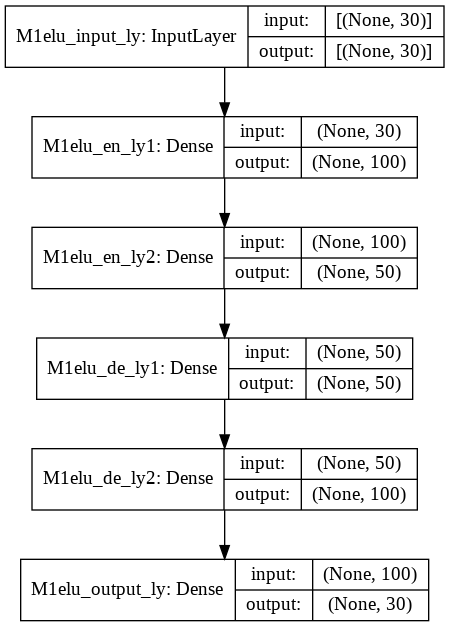

In [ ]:
plot_model(autoencoder_01_elu,show_shapes=True)

In [ ]:
au_01_elu_his = autoencoder_01_elu.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.3827 - val_loss: 0.1564
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1031 - val_loss: 0.0163
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0109 - val_loss: 0.0058
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.005

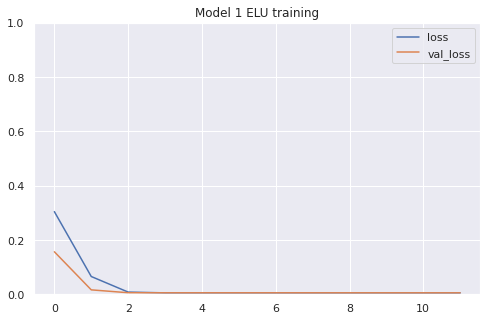

In [ ]:
pd.DataFrame(au_01_elu_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 1 ELU training")
plt.gca().set_ylim(0, 1)
plt.show()

Visualization

In [ ]:
encoder_layer_rep_m1_elu = Sequential([
                autoencoder_01_elu.layers[0],
                autoencoder_01_elu.layers[1],
                autoencoder_01_elu.layers[2]                
])
norm_hid_rep_m1_elu = encoder_layer_rep_m1_elu.predict(x_norm[:3000])
fraud_hid_rep_m1_elu = encoder_layer_rep_m1_elu.predict(x_fraud[:200])

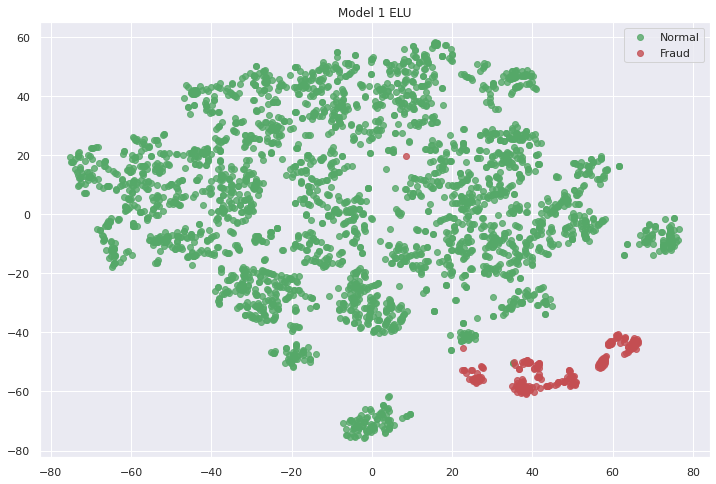

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m1_elu, fraud_hid_rep_m1_elu, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 1 ELU")

Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.92      0.74      0.82       344

    accuracy                           1.00    199365
   macro avg       0.96      0.87      0.91    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   254     90]
 [    23 198998]]
Accuracy Score:  0.9994332004113059
Precision Score:  0.9169675090252708
Recall Score:  0.7383720930232558
F1 Score:  0.8180354267310789


Text(0.5, 1.0, 'Model 1 ELU Precision-Recall curve')

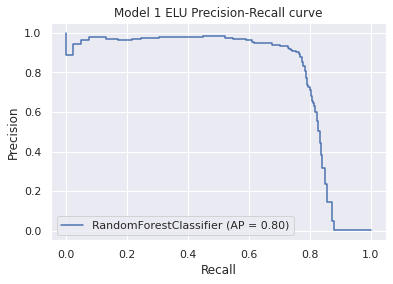

In [ ]:
train_x_transform_m1_elu = encoder_layer_rep_m1_elu.predict(train_x)
val_x_transform_m1_elu = encoder_layer_rep_m1_elu.predict(val_x)
clf_m1_elu = RandomForestClassifier().fit(train_x_transform_m1_elu, train_y)
pred_y_m1_elu = clf_m1_elu.predict(val_x_transform_m1_elu)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m1_elu))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m1_elu, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m1_elu))
print ("Precision Score: ", precision_score(val_y, pred_y_m1_elu))
print ("Recall Score: ", recall_score(val_y, pred_y_m1_elu))
print ("F1 Score: ", f1_score(val_y, pred_y_m1_elu))

# PR-AUC

disp_m1_elu = plot_precision_recall_curve(clf_m1_elu, val_x_transform_m1_elu, val_y)
disp_m1_elu.ax_.set_title('Model 1 ELU Precision-Recall curve')

##Optimizer: adam ; Activation function: tanh

Model building

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M1ADAM_tanh_input_ly")

# encoder layer
en_layers1 = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5), name="M1ADAM_tanh_en_ly1")(in_layer)
en_layers2 = Dense(50, activation='tanh', name="M1ADAM_tanh_en_ly2")(en_layers1)

# decoder layer
de_layers1 = Dense(50, activation='tanh', name="M1ADAM_tanh_de_ly1")(en_layers2)
de_layers2 = Dense(100, activation='tanh', name="M1ADAM_tanh_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='tanh',name="M1ADAM_tanh_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_01_adam_tanh = Model(in_layer, out_layer)
autoencoder_01_adam_tanh.compile(optimizer="adam", loss="mse")
autoencoder_01_adam_tanh.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M1ADAM_tanh_input_ly (InputL [(None, 30)]              0         
_________________________________________________________________
M1ADAM_tanh_en_ly1 (Dense)   (None, 100)               3100      
_________________________________________________________________
M1ADAM_tanh_en_ly2 (Dense)   (None, 50)                5050      
_________________________________________________________________
M1ADAM_tanh_de_ly1 (Dense)   (None, 50)                2550      
_________________________________________________________________
M1ADAM_tanh_de_ly2 (Dense)   (None, 100)               5100      
_________________________________________________________________
M1ADAM_tanh_output_ly (Dense (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
______________________________________________________

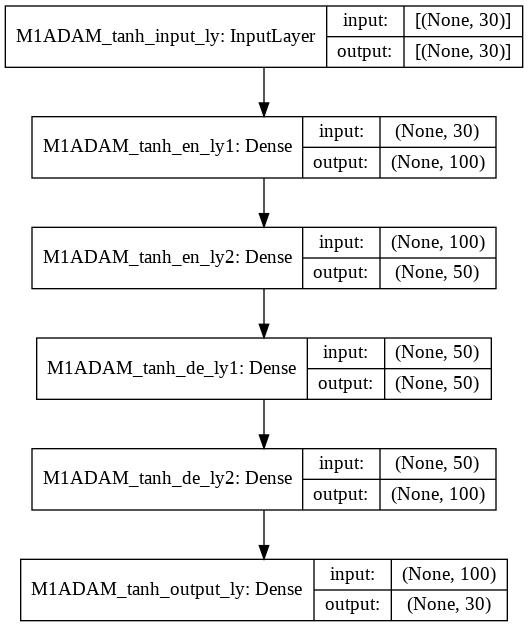

In [ ]:
plot_model(autoencoder_01_adam_tanh,show_shapes=True)

In [ ]:
au_01_adam_tanh_his = autoencoder_01_adam_tanh.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0081 - val_loss: 4.7850e-04
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 4.2230e-04 - val_loss: 3.0604e-04
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 2.8159e-04 - val_loss: 3.4096e-04
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 2.3696e-04 - val_loss: 2.2140e-04
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 2.0569e-04 - val_loss: 1.8965e-04
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 1.7939e-04 - val_loss: 2.1710e-04
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 1.7387e-04 - val_loss: 1.7452e-04
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 1.5898e-04 - val_loss: 1.5041e-04
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 1.5114e-04 - val_loss: 1.2625e-04
Epoch 10/12
16

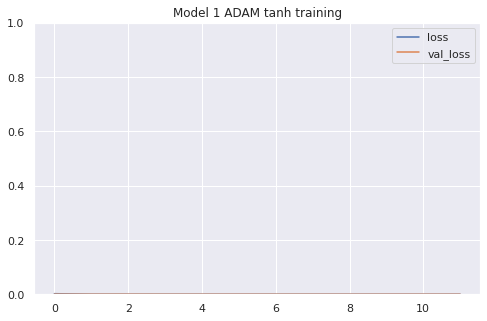

In [ ]:
pd.DataFrame(au_01_adam_tanh_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 1 ADAM tanh training")
plt.gca().set_ylim(0, 1)
plt.show()

Visualization

In [ ]:
encoder_layer_rep_m1_adam_tanh = Sequential([
                autoencoder_01_adam_tanh.layers[0],
                autoencoder_01_adam_tanh.layers[1],
                autoencoder_01_adam_tanh.layers[2]                
])
norm_hid_rep_m1_adam_tanh = encoder_layer_rep_m1_adam_tanh.predict(x_norm[:3000])
fraud_hid_rep_m1_adam_tanh = encoder_layer_rep_m1_adam_tanh.predict(x_fraud[:200])

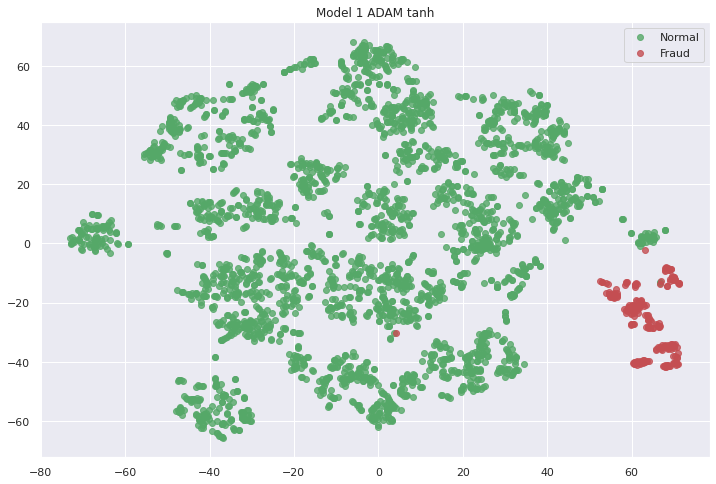

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m1_adam_tanh, fraud_hid_rep_m1_adam_tanh, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 1 ADAM tanh")

Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.92      0.73      0.81       344

    accuracy                           1.00    199365
   macro avg       0.96      0.86      0.91    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   251     93]
 [    22 198999]]
Accuracy Score:  0.9994231685601785
Precision Score:  0.9194139194139194
Recall Score:  0.7296511627906976
F1 Score:  0.813614262560778


Text(0.5, 1.0, 'Model 1 ADAM tanh Precision-Recall curve')

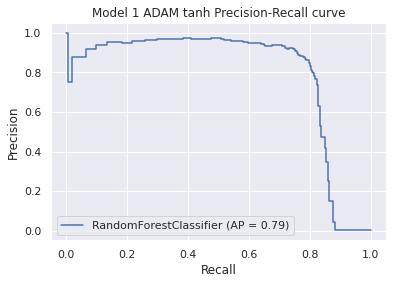

In [ ]:
train_x_transform_m1_adam_tanh = encoder_layer_rep_m1_adam_tanh.predict(train_x)
val_x_transform_m1_adam_tanh = encoder_layer_rep_m1_adam_tanh.predict(val_x)
clf_m1_adam_tanh = RandomForestClassifier().fit(train_x_transform_m1_adam_tanh, train_y)
pred_y_m1_adam_tanh = clf_m1_adam_tanh.predict(val_x_transform_m1_adam_tanh)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m1_adam_tanh))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m1_adam_tanh, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m1_adam_tanh))
print ("Precision Score: ", precision_score(val_y, pred_y_m1_adam_tanh))
print ("Recall Score: ", recall_score(val_y, pred_y_m1_adam_tanh))
print ("F1 Score: ", f1_score(val_y, pred_y_m1_adam_tanh))

# PR-AUC

disp_m1_adam_tanh = plot_precision_recall_curve(clf_m1_adam_tanh, val_x_transform_m1_adam_tanh, val_y)
disp_m1_adam_tanh.ax_.set_title('Model 1 ADAM tanh Precision-Recall curve')

##Optimizer: adam ; Activation function: RELU

Model building

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M1ADAM_relu_input_ly")

# encoder layer
en_layers1 = Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5), name="M1ADAM_relu_en_ly1")(in_layer)
en_layers2 = Dense(50, activation='relu', name="M1ADAM_relu_en_ly2")(en_layers1)

# decoder layer
de_layers1 = Dense(50, activation='relu', name="M1ADAM_relu_de_ly1")(en_layers2)
de_layers2 = Dense(100, activation='relu', name="M1ADAM_relu_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='relu',name="M1ADAM_relu_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_01_adam_relu = Model(in_layer, out_layer)
autoencoder_01_adam_relu.compile(optimizer="adam", loss="mse")
autoencoder_01_adam_relu.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M1ADAM_relu_input_ly (InputL [(None, 30)]              0         
_________________________________________________________________
M1ADAM_relu_en_ly1 (Dense)   (None, 100)               3100      
_________________________________________________________________
M1ADAM_relu_en_ly2 (Dense)   (None, 50)                5050      
_________________________________________________________________
M1ADAM_relu_de_ly1 (Dense)   (None, 50)                2550      
_________________________________________________________________
M1ADAM_relu_de_ly2 (Dense)   (None, 100)               5100      
_________________________________________________________________
M1ADAM_relu_output_ly (Dense (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
______________________________________________________

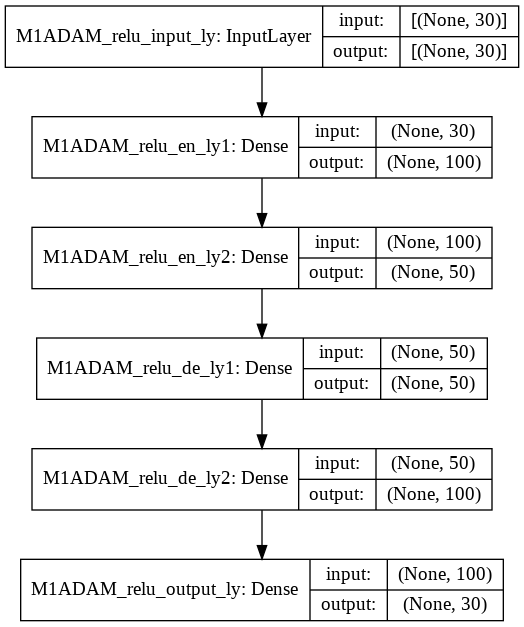

In [ ]:
plot_model(autoencoder_01_adam_relu,show_shapes=True)

In [ ]:
au_01_adam_relu_his = autoencoder_01_adam_relu.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1161 - val_loss: 0.1132
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0782 - val_loss: 0.0486
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0470 - val_loss: 0.0487
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0469 - val_loss: 0.0485
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0468 - val_loss: 0.0485
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0468 - val_loss: 0.0484
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0468 - val_loss: 0.0484
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0467 - val_loss: 0.0484
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0467 - val_loss: 0.0483
Epoch 10/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.046

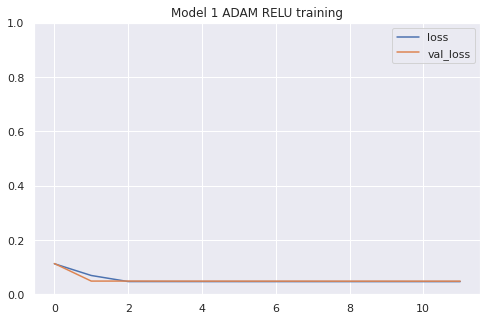

In [ ]:
pd.DataFrame(au_01_adam_relu_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 1 ADAM RELU training")
plt.gca().set_ylim(0, 1)
plt.show()

Visualization

In [ ]:
encoder_layer_rep_m1_adam_relu = Sequential([
                autoencoder_01_adam_relu.layers[0],
                autoencoder_01_adam_relu.layers[1],
                autoencoder_01_adam_relu.layers[2]                
])
norm_hid_rep_m1_adam_relu = encoder_layer_rep_m1_adam_relu.predict(x_norm[:3000])
fraud_hid_rep_m1_adam_relu = encoder_layer_rep_m1_adam_relu.predict(x_fraud[:200])

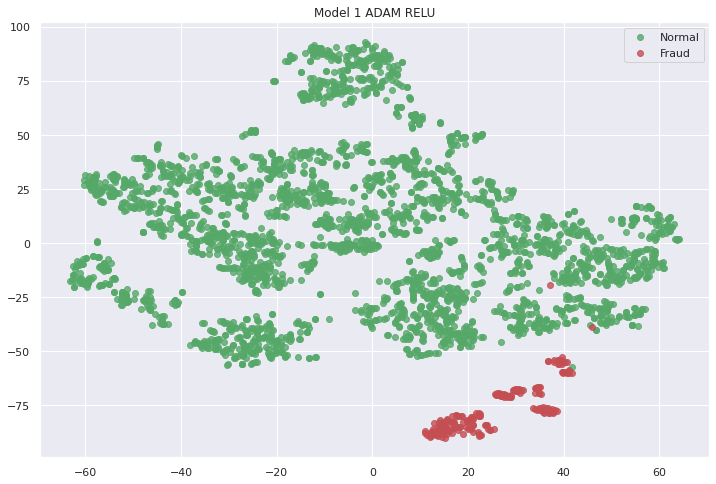

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m1_adam_relu, fraud_hid_rep_m1_adam_relu, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 1 ADAM RELU")

Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.94      0.53      0.67       344

    accuracy                           1.00    199365
   macro avg       0.97      0.76      0.84    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   181    163]
 [    12 199009]]
Accuracy Score:  0.9991222130263587
Precision Score:  0.9378238341968912
Recall Score:  0.5261627906976745
F1 Score:  0.6741154562383613


Text(0.5, 1.0, 'Model 1 ADAM RELU Precision-Recall curve')

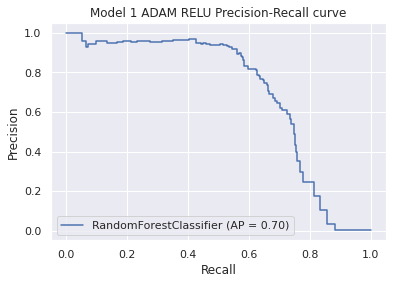

In [ ]:
train_x_transform_m1_adam_relu = encoder_layer_rep_m1_adam_relu.predict(train_x)
val_x_transform_m1_adam_relu = encoder_layer_rep_m1_adam_relu.predict(val_x)
clf_m1_adam_relu = RandomForestClassifier().fit(train_x_transform_m1_adam_relu, train_y)
pred_y_m1_adam_relu = clf_m1_adam_relu.predict(val_x_transform_m1_adam_relu)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_m1_adam_relu))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_m1_adam_relu, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_m1_adam_relu))
print ("Precision Score: ", precision_score(val_y, pred_y_m1_adam_relu))
print ("Recall Score: ", recall_score(val_y, pred_y_m1_adam_relu))
print ("F1 Score: ", f1_score(val_y, pred_y_m1_adam_relu))

# PR-AUC

disp_m1_adam_relu = plot_precision_recall_curve(clf_m1_adam_relu, val_x_transform_m1_adam_relu, val_y)
disp_m1_adam_relu.ax_.set_title('Model 1 ADAM RELU Precision-Recall curve')

##Optimizer: adam ; Activation function: ELU

Model building

In [ ]:
# input layer
in_layer = Input(shape=(X.shape[1],),name="M1ADAM_elu_input_ly")

# encoder layer
en_layers1 = Dense(100, activation='elu', activity_regularizer=regularizers.l1(10e-5), name="M1ADAM_elu_en_ly1")(in_layer)
en_layers2 = Dense(50, activation='elu', name="M1ADAM_elu_en_ly2")(en_layers1)

# decoder layer
de_layers1 = Dense(50, activation='elu', name="M1ADAM_elu_de_ly1")(en_layers2)
de_layers2 = Dense(100, activation='elu', name="M1ADAM_elu_de_ly2")(de_layers1)

# output layer
out_layer = Dense(X.shape[1], activation='elu',name="M1ADAM_elu_output_ly")(de_layers2)

# combine encoder and decoder
autoencoder_01_adam_elu = Model(in_layer, out_layer)
autoencoder_01_adam_elu.compile(optimizer="adam", loss="mse")
autoencoder_01_adam_elu.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
M1ADAM_elu_input_ly (InputLa [(None, 30)]              0         
_________________________________________________________________
M1ADAM_elu_en_ly1 (Dense)    (None, 100)               3100      
_________________________________________________________________
M1ADAM_elu_en_ly2 (Dense)    (None, 50)                5050      
_________________________________________________________________
M1ADAM_elu_de_ly1 (Dense)    (None, 50)                2550      
_________________________________________________________________
M1ADAM_elu_de_ly2 (Dense)    (None, 100)               5100      
_________________________________________________________________
M1ADAM_elu_output_ly (Dense) (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
______________________________________________________

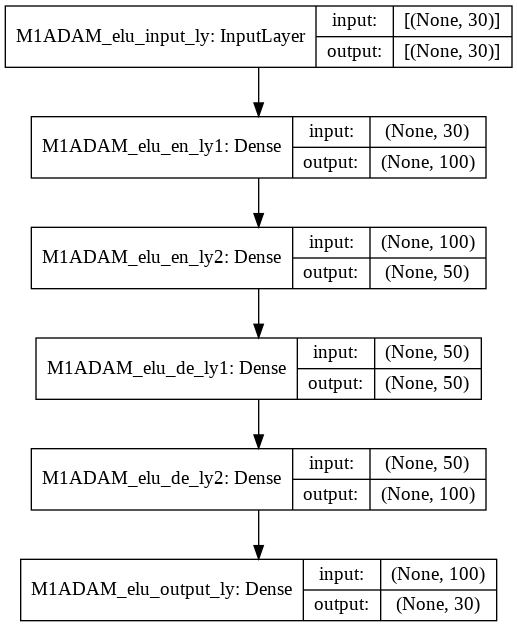

In [ ]:
plot_model(autoencoder_01_adam_elu,show_shapes=True)

In [ ]:
au_01_adam_elu_his = autoencoder_01_adam_elu.fit(x_norm[0:10000], x_norm[0:10000], 
                batch_size = 5, epochs = 12, 
                shuffle = True, validation_split = 0.20);

Epoch 1/12
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0069 - val_loss: 4.5687e-04
Epoch 2/12
1600/1600 [==============================] - 3s 2ms/step - loss: 3.7990e-04 - val_loss: 2.6537e-04
Epoch 3/12
1600/1600 [==============================] - 3s 2ms/step - loss: 2.4394e-04 - val_loss: 2.4346e-04
Epoch 4/12
1600/1600 [==============================] - 3s 2ms/step - loss: 2.0163e-04 - val_loss: 1.8601e-04
Epoch 5/12
1600/1600 [==============================] - 3s 2ms/step - loss: 1.8160e-04 - val_loss: 2.5034e-04
Epoch 6/12
1600/1600 [==============================] - 3s 2ms/step - loss: 1.6030e-04 - val_loss: 1.8948e-04
Epoch 7/12
1600/1600 [==============================] - 3s 2ms/step - loss: 1.5033e-04 - val_loss: 1.5576e-04
Epoch 8/12
1600/1600 [==============================] - 3s 2ms/step - loss: 1.3684e-04 - val_loss: 1.4198e-04
Epoch 9/12
1600/1600 [==============================] - 3s 2ms/step - loss: 1.4208e-04 - val_loss: 1.0484e-04
Epoch 10/12
16

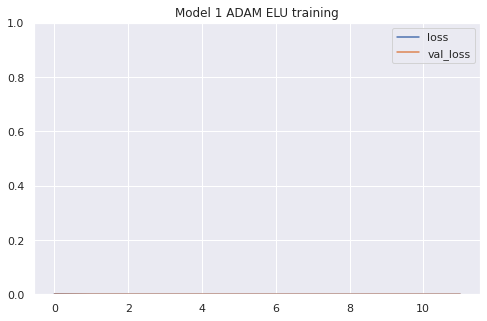

In [ ]:
pd.DataFrame(au_01_adam_elu_his.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Model 1 ADAM ELU training")
plt.gca().set_ylim(0, 1)
plt.show()

Visualization

In [ ]:
encoder_layer_rep_m1_adam_elu = Sequential([
                autoencoder_01_adam_elu.layers[0],
                autoencoder_01_adam_elu.layers[1],
                autoencoder_01_adam_elu.layers[2]                
])
norm_hid_rep_m1_adam_elu = encoder_layer_rep_m1_adam_elu.predict(x_norm[:3000])
fraud_hid_rep_m1_adam_elu = encoder_layer_rep_m1_adam_elu.predict(x_fraud[:200])

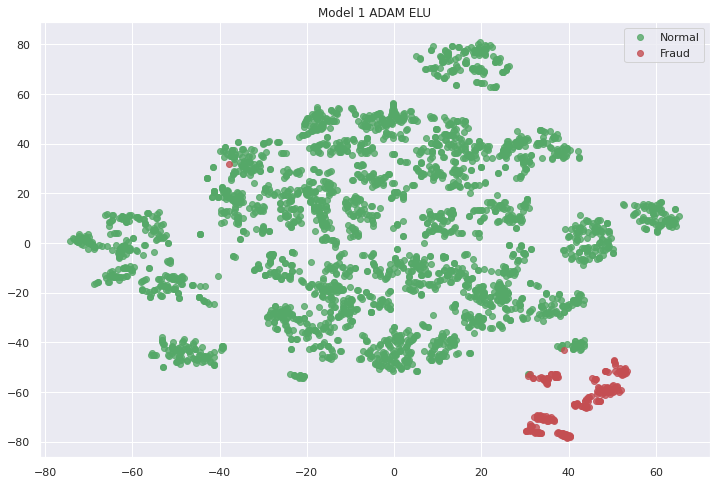

In [ ]:
## Visualize the encoder representaion using TSNE
rep_x = np.append(norm_hid_rep_m1_adam_elu, fraud_hid_rep_m1_adam_elu, axis = 0)
# rep_y are the same for all model
tsne_plot(rep_x, rep_y, "Model 1 ADAM ELU")

Evaluation


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199021
           1       0.93      0.77      0.84       344

    accuracy                           1.00    199365
   macro avg       0.96      0.89      0.92    199365
weighted avg       1.00      1.00      1.00    199365


Confusion Matrix: 
 [[   266     78]
 [    21 199000]]
Accuracy Score:  0.9995034233691972
Precision Score:  0.926829268292683
Recall Score:  0.7732558139534884
F1 Score:  0.8431061806656102


Text(0.5, 1.0, 'Model 1 ADAM ELU Precision-Recall curve')

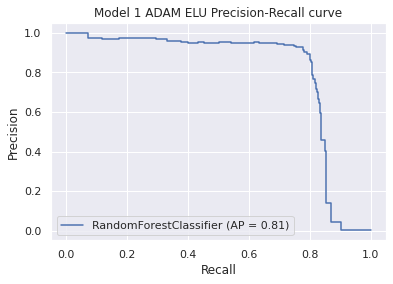